In [2]:
import os
import yaml
import importlib
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import numpy as np
import pyarrow.parquet as pq
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder 
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

2022-01-24 14:32:18.322356: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /cvmfs/sft.cern.ch/lcg/releases/MCGenerators/thepeg/2.2.1-8d929/x86_64-centos7-gcc10-opt/lib/ThePEG:/cvmfs/sft.cern.ch/lcg/releases/MCGenerators/herwig++/7.2.1-f3599/x86_64-centos7-gcc10-opt/lib/Herwig:/cvmfs/sft.cern.ch/lcg/views/LCG_101/x86_64-centos7-gcc10-opt/lib/python3.9/site-packages/torch/lib:/cvmfs/sft.cern.ch/lcg/views/LCG_101/x86_64-centos7-gcc10-opt/lib/python3.9/site-packages/tensorflow:/cvmfs/sft.cern.ch/lcg/views/LCG_101/x86_64-centos7-gcc10-opt/lib/python3.9/site-packages/tensorflow/contrib/tensor_forest:/cvmfs/sft.cern.ch/lcg/views/LCG_101/x86_64-centos7-gcc10-opt/lib/python3.9/site-packages/tensorflow/python/framework:/cvmfs/sft.cern.ch/lcg/releases/java/8u222-884d8/x86_64-centos7-gcc10-opt/jre/lib/amd64:/cvmfs/sft.cern.ch/l

In [3]:
### Parameters of the training ###

#split = "even" 
split = "odd" 
# split = even | odd -> on what split to train the model (will be in the name)
# -> you need one "odd" and one "even" models to be put inside bamboo

suffix = 'test'
# Suffix that will be added to the saved model (so multiple DNNs can be trained)

quantile = 0.95 # We will repeat the part of the weights rightmost tail
# Eg : 0.95, means we take the 5% events on the right tail of training weight and repeat them
# 1.0 means no correction (to be used if you want to diable it)

tags = ['HH','background','single H']
importance = [0.1,1.,1.] # Importance of each category

# DNN hyperparameters #
parameters = {
    'epochs'                : 200,
    'lr'                    : 0.001,
    'batch_size'            : 256,
    'n_layers'              : 3,
    'n_neurons'             : 64,
    'hidden_activation'     : 'relu',
    'output_activation'     : 'softmax',
    'l2'                    : 1e-6,
    'dropout'               : 0.,
    'batch_norm'            : True,
}
# L2 is an additional term in the loss function : l2 x ||W||**2 where ||W|| is the sum of all the DNN weights 
#    inside the neurons
# -> when overfitting the weights take large values, this tells the optimizer the trade off between performances
#    and generalization (from experience, a small value always helps)
# Dropout is a frequency of killing neurons at each batch (no backprogation for them)
# -> used generally when overfitting is detected, to avoid that the DNN learns too much 
#    (from experience, not always useful, put it when you see overfitting)
# Batch normalization is a layer that normalizes the output of each neuron (see documentation)
# -> usually helps that the gradient does not go too far and backprogation is always smooth (supposedly)
#    (from experience : always used it, maybe not worth all the time)


# Input variables
input_vars=["Eta_ph1",
            "Phi_ph1",
            "E_mGG_ph1",
            "pT_mGG_ph1",
            "Eta_ph2",
            "Phi_ph2",
            "E_mGG_ph2",
            "pT_mGG_ph2",
            "Electron_E",
            "Electron_pT",
            "Electron_Eta",
            "Electron_Phi",
            "Muon_E",
            "Muon_pT",
            "Muon_Eta",
            "Muon_Phi",
            "nJets",
            "E_jet1",
            "pT_jet1",
            "Eta_jet1",
            "Phi_jet1",
            "E_jet2",
            "pT_jet2",
            "Eta_jet2",
            "Phi_jet2",
            "InvM_jet",
            "InvM_jet2",
            "met"]

In [4]:
# Load the required data #
outputPath = '/home/ucl/cp3/sdonerta/bamboodev/WWGG/10_11_Skim_Slurm/'
skimFile = os.path.join(outputPath,'results','Skim.parquet')
yamlFile = os.path.join(outputPath,'plots.yml')

# Load dataframe from parquet #
df = pd.read_parquet(skimFile)

# Load samples + plots data from yaml file #
with open(yamlFile,'r') as handle:
    config = yaml.load(handle)


/nfs/scratch/fynu/fbury/ipykernel_2783870/3780820245.py:11: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  config = yaml.load(handle)


In [5]:
# Cut negative event weights #
df = df[(df['weight']>0) & (df['weight']<300)]
#df = df[df['weight']>0]

# Cut QCD events #
df = df[~df.process.str.contains("QCD")]


In [6]:
# Add tag column #
if 'tag' in df.columns:
    del df['tag']

df['tag'] = 'background'
for singleH in ['VBFH','VH','THQ','GluGluHTo']:
    df.loc[df.process.str.contains(singleH),['tag']] = 'single H'
df.loc[df.process.str.contains('HH'),['tag']] = 'HH'

for tag in tags:
    if tag in df.columns:
        del df[tag]

assert len(set(tags).intersection(set(pd.unique(df['tag'])))) == len(tags) # Just cross check to avoid mistakes
# Add onehot column #
label_encoder  = LabelEncoder()                                                                                                                                                              
onehot_encoder = OneHotEncoder(sparse=False)
label_encoder.fit(tags)
integers = label_encoder.transform(df['tag']).reshape(-1, 1)
onehot_encoder.fit(np.arange(len(tags)).reshape(-1, 1))
onehot = onehot_encoder.transform(integers)
onehot_df = pd.DataFrame(onehot,columns=tags,index=df.index)

df = pd.concat((df,onehot_df),axis=1)

In [7]:
print(df)

       weight   Eta_ph1   Phi_ph1  E_mGG_ph1  pT_mGG_ph1   Eta_ph2   Phi_ph2  \
0    0.000025  1.151401  2.699523   1.979170    1.137842  1.603054  1.725826   
1    0.000025 -2.393572 -2.922358   2.951623    0.534528 -2.449574  0.575581   
2    0.000025  0.276418  0.034514   0.957748    0.922289  1.291733  2.735958   
3    0.000025  1.962913 -3.129909   4.803318    1.323140  2.307431 -2.418910   
4    0.000025 -1.630125 -1.711777   1.767290    0.666849 -0.139589 -1.830953   
..        ...       ...       ...        ...         ...       ...       ...   
687  0.784736  0.892076 -0.133293   0.600080    0.421109 -1.847214 -0.196785   
688  0.784736  2.357798  0.196086   8.277598    1.552687  2.074468 -2.216101   
689  0.784736  0.037749  2.375303   0.662115    0.661643  1.665867  2.953054   
690  0.784736  2.519501  1.856302   4.363004    0.697919  1.706206 -0.204428   
691  0.784736 -1.269456  1.293445   1.083464    0.564319  0.837923 -0.183357   

     E_mGG_ph2  pT_mGG_ph2  Electron_E 

In [8]:
# Produce physical event weight #
df['event_weight'] = pd.Series(np.zeros(df.shape[0]))
lumi = config['configuration']['luminosity']['HL-LHC']
for process in pd.unique(df['process']):
    print (f'Looking at process {process}')
    if 'cross-section' in config['files'][process].keys() and config['files'][process]['type'] != 'signal':
        cross_section = config["files"][process]["cross-section"]
    else:
        cross_section = 1.
        # For signal, we assume unit cross section (otherwise significance can be too unstable)
    if 'branching-ratio' in config['files'][process].keys():
        BR = config["files"][process]["branching-ratio"]
    else:
        BR = 1
    if 'generated-events' in config['files'][process].keys():
        
        generated_events = config["files"][process]["generated-events"]
    else:
        raise RuntimeError('Process {process} is missing `generated-events` entry, should not happen')
        
    print (f'... cross-section = {cross_section}')
    print (f'... branching-ratio = {BR}')
    print (f'... generated-events = {generated_events}')
    factor = lumi * cross_section * BR / generated_events
    # We don't really care about luminosity because the scale of the weights do not matter, and you have a single lumi
    print (f'   -> Total factor = {factor}')
    # Apply to the new event_weight columns #
    df.loc[df["process"]==process,'event_weight'] = df[df["process"]==process]['weight'] * factor
    print (f'   Sum of weights = {df[df["process"]==process]["weight"].sum()} -> {df[df["process"]==process]["event_weight"].sum()}')


if (df['event_weight'] < 0).sum() > 0:
    raise RuntimeError(f"There are {(df['event_weight'] < 0).sum()} events with negative event weight, this should not happen")

Looking at process GluGluToHHTo2G2Qlnu_node_cHHH1_TuneCP5_14TeV-powheg-pythia8_200PU.root
... cross-section = 1.0
... branching-ratio = 1
... generated-events = 65241.65374448523
   -> Total factor = 45.982893256343694
   Sum of weights = 2.345959186553955 -> 107.87401476898096
Looking at process GluGluHToGG_M125_TuneCP5_14TeV-amcatnloFXFX-pythia8_200PU.root
... cross-section = 0.114798
... branching-ratio = 1
... generated-events = 55033679.55371094
   -> Total factor = 0.00625787704534427
   Sum of weights = 414.35626220703125 -> 2.5929905269294977
Looking at process VBFHToGG_M125_TuneCP5_14TeV-amcatnlo-pythia8_200PU.root
... cross-section = 0.00951216
... branching-ratio = 1
... generated-events = 7894933.640413284
   -> Total factor = 0.003614530697753423
   Sum of weights = 132.13275146484375 -> 0.47759788983967155
Looking at process ttHJetToGG_M125_TuneCP5_14TeV-amcatnloFXFX-madspin-pythia8_200PU.root
... cross-section = 0.001393764
... branching-ratio = 1
... generated-events = 

In [9]:
# Compute training weight #
if 'training_weight' in df.columns:
    del df['training_weight']
df['training_weight'] = df['event_weight'].copy()

for itag,tag in enumerate(tags):
    df.loc[df['tag']==tag,'training_weight'] *= importance[itag] * df.shape[0]/ len(tags) / df[df['tag']==tag]['event_weight'].sum()


In [10]:
import utils
importlib.reload(utils) # Reload in case file has changed
print ('Using event weight')
utils.checkBatches(df,label_column='tag',weight_column='event_weight',batch_size=parameters['batch_size'])
print ('Using training weight')
utils.checkBatches(df,label_column='tag',weight_column='training_weight',batch_size=parameters['batch_size'])

Using event weight
On average, per batch the total weight is
	... HH                  :     0.083193297 [70.96 events]
	... single H            :     0.002887782 [38.57 events]
	... background          : 22077.827048651 [146.47 events]
Using training weight
On average, per batch the total weight is
	... HH                  :     8.619747525 [72.04 events]
	... single H            :    89.654663992 [38.45 events]
	... background          :    84.663424354 [145.51 events]


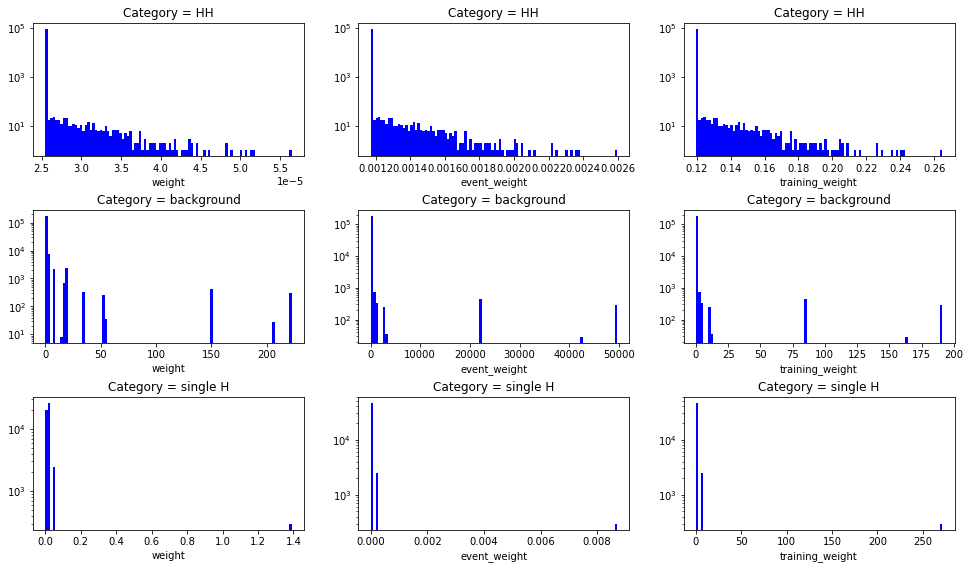

In [11]:
# Plot the background and signal weights #
fig,axs = plt.subplots(figsize=(16,8),nrows=len(tags),ncols=3)
fig.subplots_adjust(left=0.1, right=0.9, top=0.98, bottom=0.1, wspace=0.2,hspace=0.4)
for irow,tag in enumerate(tags):
    for icol,column in enumerate(['weight','event_weight','training_weight']):
        axs[irow,icol].hist(df[df['tag']==tag][column],bins=100,color='b')
        axs[irow,icol].set_title(f"Category = {tag}")
        axs[irow,icol].set_xlabel(column)
        axs[irow,icol].set_yscale('log')
fig.savefig("event_weights_A.pdf", dpi = 300)


In [12]:
# Plot the weights per process #
if False:
    with PdfPages("event_weights_B.pdf") as pdf:
        for process in pd.unique(df['process']):
            fig,axs = plt.subplots(figsize=(16,6),nrows=1,ncols=3)
            fig.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1, wspace=0.2,hspace=0.3)
            fig.suptitle(f"Process {process}")
            for icol,column in enumerate(['weight','event_weight','training_weight']):
                axs[icol].hist(df[df['process']==process][column],bins=100,color='b')
                axs[icol].set_xlabel(column)
                axs[icol].set_xlim(0,(df[df['process']==process][column]).max()*1.5)
                axs[icol].set_yscale('log')
            pdf.savefig()
            plt.close(fig)

In [13]:
print(df[input_vars])

      Eta_ph1   Phi_ph1  E_mGG_ph1  pT_mGG_ph1   Eta_ph2   Phi_ph2  E_mGG_ph2  \
0    1.151401  2.699523   1.979170    1.137842  1.603054  1.725826   2.097534   
1   -2.393572 -2.922358   2.951623    0.534528 -2.449574  0.575581   2.815203   
2    0.276418  0.034514   0.957748    0.922289  1.291733  2.735958   0.430226   
3    1.962913 -3.129909   4.803318    1.323140  2.307431 -2.418910   6.344330   
4   -1.630125 -1.711777   1.767290    0.666849 -0.139589 -1.830953   0.565238   
..        ...       ...        ...         ...       ...       ...        ...   
687  0.892076 -0.133293   0.600080    0.421109 -1.847214 -0.196785   0.569781   
688  2.357798  0.196086   8.277598    1.552687  2.074468 -2.216101   0.728969   
689  0.037749  2.375303   0.662115    0.661643  1.665867  2.953054   1.145351   
690  2.519501  1.856302   4.363004    0.697919  1.706206 -0.204428   1.119852   
691 -1.269456  1.293445   1.083464    0.564319  0.837923 -0.183357   0.297948   

     pT_mGG_ph2  Electron_E

In [98]:
# Determine splitting variable #
split_var = df['Phi_ph1'].copy()
split_var *= 1e4
split_var -= np.floor(split_var) 
split_var = (split_var*1e1).astype(int)
split_var = split_var %2 == 0
print (f'Even set has {df[split_var].shape[0]:10d} events [{df[split_var].shape[0]/df.shape[0]*100:5.2f}%]')
print (f'Odd  set has {df[~split_var].shape[0]:10d} events [{df[~split_var].shape[0]/df.shape[0]*100:5.2f}%]')

Even set has     164886 events [49.94%]
Odd  set has     165275 events [50.06%]


In [99]:
# Sets splitting #
print (f'Using split type {split}')
# split_var = True (even number) | False (odd number)
# Name of the model is related to the even | odd quality of the events during inference (ie, in bamboo)
if split == 'even':
    train_df = df[~split_var] # Trained on odd
    test_df  = df[split_var]  # Evaluated on even 
elif split == 'odd':
    train_df = df[split_var]  # Trained on even
    test_df  = df[~split_var] # Evaluated on odd 
else:
    raise RuntimeError(f'Split needs to be either odd or even, is {split}')

# Randomize for training (always good to randomize) #
train_df = train_df.sample(frac=1)

# Quantile corrections #
# When an event has a large weight, it can imbalance a lot the training, still the weight might have a meaning
# Idea : instead of 1 event with wi>>1, we use N copies of the event with wf = wi/N
# From the point of view of the physics it does not matter, the total event weight sum of each process is the same
# From the point of view of the DNN, we have split a tough nut to crack into several smaller ones

quantile_lim = train_df['training_weight'].quantile(quantile)
print (f'{(1-quantile)*100:5.2f}% right quantile is when weight is at {quantile_lim}')
print ('  -> These events will be repeated and their learning weights reduced accordingly to avoid unstability') 

# Select the events #
idx_to_repeat = train_df['training_weight'] >= quantile_lim                          
events_excess = train_df[idx_to_repeat].copy()

saved_columns = train_df[['training_weight','process']].copy()

# Compute multiplicative factor #
factor = (events_excess['training_weight']/quantile_lim).values.astype(np.int32) 

# Correct the weights of events already in df #
train_df.loc[idx_to_repeat,'training_weight'] /= factor

# Add N-1 copies #
arr_to_repeat = train_df[idx_to_repeat].values                                       
repetition = np.repeat(np.arange(arr_to_repeat.shape[0]), factor-1)                   
df_repeated = pd.DataFrame(np.take(arr_to_repeat,repetition,axis=0),columns=train_df.columns)
df_repeated = df_repeated.astype(train_df.dtypes.to_dict()) # otherwise dtypes are object
train_df = pd.concat((train_df,df_repeated),axis=0,ignore_index=True).sample(frac=1).reset_index() # Add and randomize

# Printout #
print ('Changes per process in training set')
for process in pd.unique(train_df['process']):
    N_before = saved_columns[saved_columns['process']==process].shape[0]
    N_after  = train_df[train_df['process']==process].shape[0]
    if N_before != N_after:
        print (f"{process:20s}")
        print (f"... {N_before:6d} events [sum weight = {saved_columns[saved_columns['process']==process]['training_weight'].sum():14.6f}]",end=' -> ')
        print (f"{N_after:6d} events [sum weight = {train_df[train_df['process']==process]['training_weight'].sum():14.6f}]")
    
print ()
print (f"Total entries : {saved_columns.shape[0]:14d} -> {train_df.shape[0]:14d}")
print (f"Total event sum : {saved_columns['training_weight'].sum():14.6f} -> {train_df['training_weight'].sum():14.6f}")

# Validation split #
train_df,val_df  = train_test_split(train_df,test_size=0.3)

# Printout #
print ('\nFinal sets')
print (f'Training set   = {train_df.shape[0]}')
print (f'Validation set = {val_df.shape[0]}')
print (f'Testing set    = {test_df.shape[0]}')
print (f'Total set      = {df.shape[0]}')

Using split type odd
 5.00% right quantile is when weight is at 0.5231576987519243
  -> These events will be repeated and their learning weights reduced accordingly to avoid unstability
Changes per process in training set
DYJets_incl_MLL-50_TuneCUETP8M1_14TeV-madgraphMLM-pythia8_200PU.root
...    147 events [sum weight =   28080.827180] ->  53655 events [sum weight =   28080.827180]
GluGluHToGG_M125_TuneCP5_14TeV-amcatnloFXFX-pythia8_200PU.root
...    149 events [sum weight =   40457.102276] ->  77331 events [sum weight =   40457.102276]
GJet_Pt-40toInf_DoubleEMEnriched_MGG-80toInf_TuneCUEP8M2T4_14TeV_Pythia8_200PU.root
...    202 events [sum weight =   17358.831337] ->  33128 events [sum weight =   17358.831337]
VBFHToGG_M125_TuneCP5_14TeV-amcatnlo-pythia8_200PU.root
...   1218 events [sum weight =    7391.033386] ->  13398 events [sum weight =    7391.033386]
TT_TuneCUETP8M2T4_14TeV-powheg-pythia8_200PU.root
...    137 events [sum weight =    1453.516075] ->   2740 events [sum weight

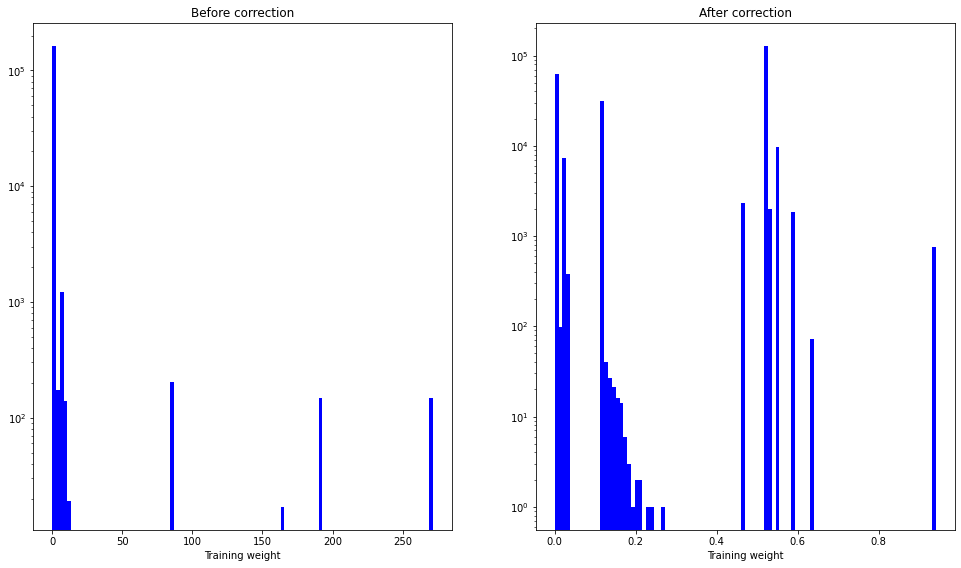

In [100]:
# Plot the background and signal weights #
fig,axs = plt.subplots(figsize=(16,8),nrows=1,ncols=2)
fig.subplots_adjust(left=0.1, right=0.9, top=0.98, bottom=0.1, wspace=0.2,hspace=0.3)

if split == 'even':
    axs[0].hist(df[~split_var]['training_weight'],bins=100,color='b')
elif split == 'odd':
    axs[0].hist(df[split_var]['training_weight'],bins=100,color='b')
axs[0].set_title("Before correction")
axs[0].set_xlabel("Training weight")
axs[0].set_yscale('log')
axs[1].hist(train_df['training_weight'],bins=100,color='b')
axs[1].set_title("After correction")
axs[1].set_xlabel("Training weight")
axs[1].set_yscale('log')
fig.savefig("event_weights_C.pdf", dpi = 300)

In [17]:
# Input layer #
inputs = keras.Input(shape=(len(input_vars),), name="particles")

# Preprocessing layer
from tensorflow.keras.layers.experimental import preprocessing
normalizer = preprocessing.Normalization(mean     = train_df[input_vars].mean(axis=0),
                                         variance = train_df[input_vars].var(axis=0),
                                         name     = 'Normalization')(inputs)
    # this layer does the preprocessing (x-mu)/std for each input
# Dense (hidden) layers #
x = normalizer
for i in range(parameters['n_layers']):
    x = layers.Dense(units                = parameters['n_neurons'], 
                     activation           = parameters['hidden_activation'], 
                     activity_regularizer = tf.keras.regularizers.l2(parameters['l2']),
                     name                 = f"dense_{i}")(x)
    if parameters['batch_norm']:
        x = layers.BatchNormalization()(x)
    if parameters['dropout'] > 0.:
        x = layers.Dropout(parameters['dropout'])(x)
# Output layer #
outputs = layers.Dense(units                = 3, 
                       activation           = parameters['output_activation'],
                       activity_regularizer = tf.keras.regularizers.l2(parameters['l2']),
                       name                 = "predictions")(x)

# Registering the model #
model = keras.Model(inputs=inputs, outputs=outputs)

2022-01-24 14:32:53.497813: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /cvmfs/sft.cern.ch/lcg/releases/MCGenerators/thepeg/2.2.1-8d929/x86_64-centos7-gcc10-opt/lib/ThePEG:/cvmfs/sft.cern.ch/lcg/releases/MCGenerators/herwig++/7.2.1-f3599/x86_64-centos7-gcc10-opt/lib/Herwig:/cvmfs/sft.cern.ch/lcg/views/LCG_101/x86_64-centos7-gcc10-opt/lib/python3.9/site-packages/torch/lib:/cvmfs/sft.cern.ch/lcg/views/LCG_101/x86_64-centos7-gcc10-opt/lib/python3.9/site-packages/tensorflow:/cvmfs/sft.cern.ch/lcg/views/LCG_101/x86_64-centos7-gcc10-opt/lib/python3.9/site-packages/tensorflow/contrib/tensor_forest:/cvmfs/sft.cern.ch/lcg/views/LCG_101/x86_64-centos7-gcc10-opt/lib/python3.9/site-packages/tensorflow/python/framework:/cvmfs/sft.cern.ch/lcg/releases/java/8u222-884d8/x86_64-centos7-gcc10-opt/jre/lib/amd64:/cvmfs/sft.cern.ch/lcg/views/L

In [18]:
model_preprocess = keras.Model(inputs=inputs, outputs=normalizer)
out_test = model_preprocess.predict(train_df[input_vars],batch_size=5000)
print ('Input (after normalization) mean (should be close to 0)')
print (out_test.mean(axis=0))
print ('Input (after normalization) variance (should be close to 1)')
print (out_test.var(axis=0))

2022-01-24 14:32:54.357930: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2022-01-24 14:32:54.368045: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 2394070000 Hz


Input (after normalization) mean (should be close to 0)
[-8.8613259e-09  7.0584222e-10 -2.9281486e-08 -2.9065090e-08
  6.4075849e-08  5.5522904e-08  3.6162781e-08  5.4833666e-09
  1.5908114e-08  6.3004023e-08  2.9557143e-09  3.7406245e-08
  1.6657809e-06  2.2700822e-06  3.3822917e-06  7.4565509e-07
  7.0229459e-07 -1.2722055e-07  3.4984154e-07 -1.0205929e-06
  2.6096299e-07 -1.8269382e-06  2.2404164e-07 -5.9323594e-07
  1.9703454e-07  1.5162119e-06  4.6141377e-06  3.2189753e-08]
Input (after normalization) variance (should be close to 1)
[1.0000141  1.0000294  0.9999358  0.99992335 0.999939   0.9999527
 0.9999963  0.99986404 0.9998807  0.9999966  0.999879   0.9998442
 1.0025338  1.0018888  0.99998015 0.99997    0.9992946  1.0010049
 0.9991761  0.9994548  0.9999647  0.99834335 0.99839675 0.9997297
 0.9999195  0.99863684 1.0016758  0.9999456 ]


In [19]:
model.compile(
    #optimizer=keras.optimizers.RMSprop(),
    optimizer=keras.optimizers.Adam(lr=parameters['lr']),  # Optimizer
    # Loss function to minimize
    loss=keras.losses.CategoricalCrossentropy(),
    # List of metrics to monitor
    metrics=[keras.metrics.BinaryAccuracy(),
             tf.keras.metrics.AUC(),
             tf.keras.metrics.Precision(),
             tf.keras.metrics.Recall()],
)

model.summary()


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
particles (InputLayer)       [(None, 28)]              0         
_________________________________________________________________
Normalization (Normalization (None, 28)                57        
_________________________________________________________________
dense_0 (Dense)              (None, 64)                1856      
_________________________________________________________________
batch_normalization (BatchNo (None, 64)                256       
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
batch_normalization_1 (Batch (None, 64)                256       
_________________________________________________________________
dense_2 (Dense)              (None, 64)                4160  

/cvmfs/sft.cern.ch/lcg/views/LCG_101/x86_64-centos7-gcc10-opt/lib/python3.9/site-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


In [20]:
# Callbacks #
early_stopping = EarlyStopping(monitor = 'val_loss',
                               min_delta = 0.001, 
                               patience = 20,
                               verbose=1,
                               mode='min',
                               restore_best_weights=True)
# Stop the learning when val_loss stops increasing 
# https://keras.io/api/callbacks/early_stopping/

reduce_plateau = ReduceLROnPlateau(monitor = 'val_loss',
                                   factor = 0.1,
                                   min_delta = 0.001, 
                                   patience = 8,
                                   min_lr = 1e-8,
                                   verbose=2,
                                   mode='min')
# reduce LR if not improvement for some time 
# https://keras.io/api/callbacks/reduce_lr_on_plateau/
import History 
importlib.reload(History)
loss_history = History.LossHistory()

In [21]:
history = model.fit(
    train_df[input_vars],
    train_df[tags],
    verbose=2,
    batch_size=parameters['batch_size'],
    epochs=parameters['epochs'],
    sample_weight=train_df['training_weight'],
    # We pass some validation for
    # monitoring validation loss and metrics
    # at the end of each epoch
    validation_data=(val_df[input_vars],val_df[tags],val_df['training_weight']),
    callbacks = [early_stopping, reduce_plateau, loss_history],
)


Epoch 1/200
961/961 - 10s - loss: 0.1130 - binary_accuracy: 0.7972 - auc: 0.8389 - precision: 0.7087 - recall: 0.6646 - val_loss: 0.0742 - val_binary_accuracy: 0.8230 - val_auc: 0.8753 - val_precision: 0.7463 - val_recall: 0.7106
Epoch 2/200
961/961 - 5s - loss: 0.0718 - binary_accuracy: 0.8202 - auc: 0.8736 - precision: 0.7417 - recall: 0.7067 - val_loss: 0.0656 - val_binary_accuracy: 0.8202 - val_auc: 0.8742 - val_precision: 0.7422 - val_recall: 0.7056
Epoch 3/200
961/961 - 5s - loss: 0.0638 - binary_accuracy: 0.8224 - auc: 0.8779 - precision: 0.7451 - recall: 0.7101 - val_loss: 0.0606 - val_binary_accuracy: 0.8254 - val_auc: 0.8836 - val_precision: 0.7493 - val_recall: 0.7157
Epoch 4/200
961/961 - 5s - loss: 0.0591 - binary_accuracy: 0.8223 - auc: 0.8786 - precision: 0.7444 - recall: 0.7108 - val_loss: 0.0577 - val_binary_accuracy: 0.8174 - val_auc: 0.8759 - val_precision: 0.7371 - val_recall: 0.7028
Epoch 5/200
961/961 - 5s - loss: 0.0558 - binary_accuracy: 0.8232 - auc: 0.8800 - p

Epoch 36/200
961/961 - 5s - loss: 0.0326 - binary_accuracy: 0.8260 - auc: 0.8833 - precision: 0.7467 - recall: 0.7232 - val_loss: 0.0482 - val_binary_accuracy: 0.8174 - val_auc: 0.8784 - val_precision: 0.7334 - val_recall: 0.7104
Epoch 37/200
961/961 - 5s - loss: 0.0326 - binary_accuracy: 0.8263 - auc: 0.8832 - precision: 0.7473 - recall: 0.7235 - val_loss: 0.0482 - val_binary_accuracy: 0.8175 - val_auc: 0.8785 - val_precision: 0.7335 - val_recall: 0.7108

Epoch 00037: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.
Epoch 38/200
961/961 - 5s - loss: 0.0327 - binary_accuracy: 0.8262 - auc: 0.8830 - precision: 0.7473 - recall: 0.7233 - val_loss: 0.0481 - val_binary_accuracy: 0.8173 - val_auc: 0.8781 - val_precision: 0.7331 - val_recall: 0.7103
Epoch 39/200
961/961 - 5s - loss: 0.0325 - binary_accuracy: 0.8263 - auc: 0.8834 - precision: 0.7474 - recall: 0.7236 - val_loss: 0.0482 - val_binary_accuracy: 0.8175 - val_auc: 0.8783 - val_precision: 0.7335 - val_recall: 0.710

Curves saved as loss_test_odd.png


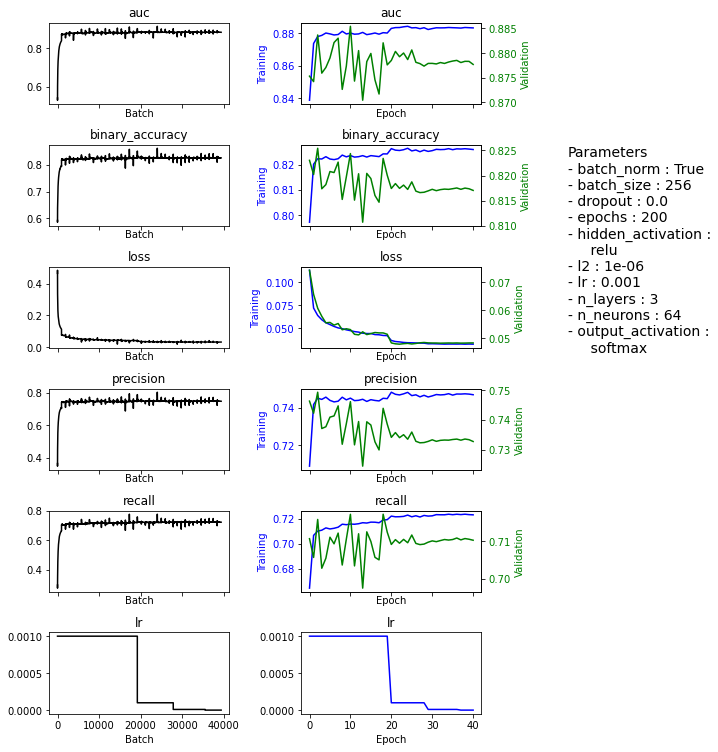

In [22]:
History.PlotHistory(loss_history,params=parameters,outputName=f'loss_{suffix}_{split}.png')
# Params is a dict of parameters with name and values
# used for plotting


In [117]:
# Produce output on the test set as new column #
output = model.predict(test_df[input_vars],batch_size=5000)
output_tags = [f'output {tag}' for tag in tags]
    # Here the batch_size arg is independent of the learning
    # Default is 32, but it can become slow, by using large value it will just compute more values in parallel
    # (more or less parallel, we are not using a GPU)
for output_tag in output_tags:
    if output_tag in test_df.columns:
        # If already output, need to remove to add again
        # avoid issues in case you run this cell multiple times
        del test_df[output_tag]

test_df = pd.concat((test_df,pd.DataFrame(output,columns=output_tags,index=test_df.index)),axis=1)
# We add the output as a column, a bit messy, different ways, here I use a concatenation

# Make the discriminator #
if 'd_HH' in test_df.columns:
    del test_df['d_HH']
    
signal_idx = [i for i,tag in enumerate(tags) if 'HH' in tag]

# d_HH = ln (P(HH) / (P(single H) + P(background)))

#test_df['d_HH'] = pd.Series(np.ones(test_df.shape[0]))

# Numerator #
num = pd.DataFrame((test_df[[output_tags[i] for i in range(len(tags)) if i in signal_idx]]).sum(axis=1))
# Denominator #
den = pd.DataFrame(test_df[[output_tags[i] for i in range(len(tags)) if i not in signal_idx]].sum(axis=1))
# Ln #
d_HH = np.log(num / den)
test_df['d_HH'] = d_HH

if df[df.isin([np.nan, np.inf, -np.inf]).any(1)].shape[0] > 0:
    raise RuntimeError('Some nan of inf values in d_HH')

ROC curve of binary classification of HH node versus all the others


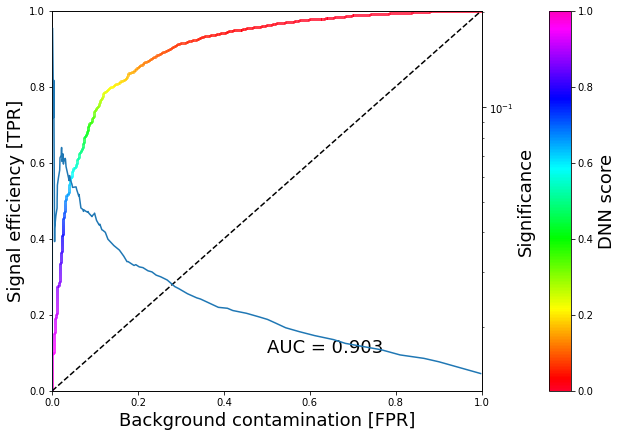

Saved ROC as roc_test_odd_HH.pdf
Best WP based on significance = 0.95944
ROC curve of binary classification of background node versus all the others


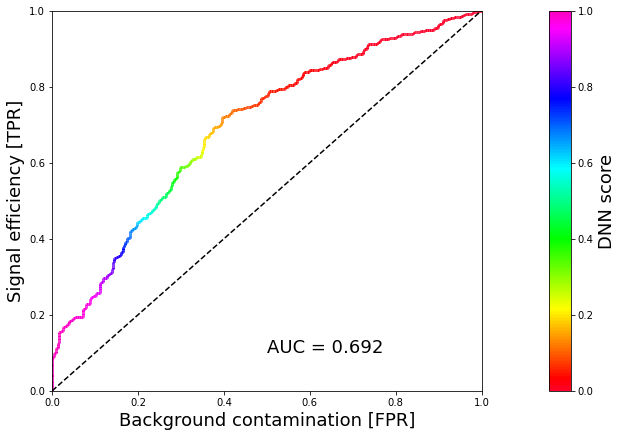

Saved ROC as roc_test_odd_background.pdf
ROC curve of binary classification of single H node versus all the others


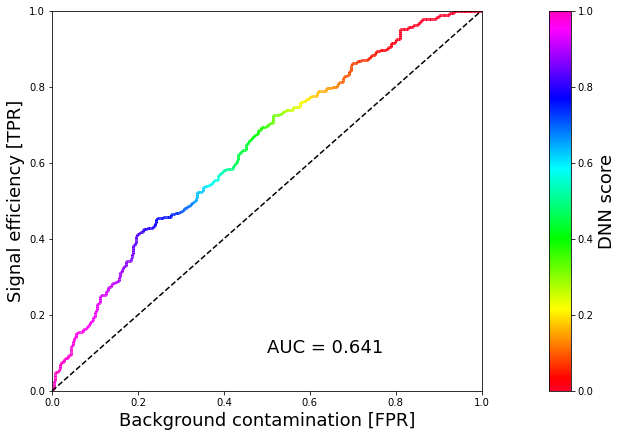

Saved ROC as roc_test_odd_single H.pdf
ROC curve of binary classification of d_HH


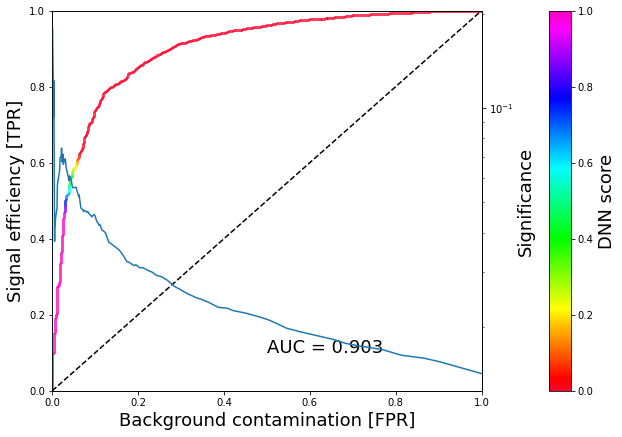

Saved ROC as roc_test_odd_d_HH.pdf
Best WP based on significance = 3.15665
Multi roc curve for `output HH`


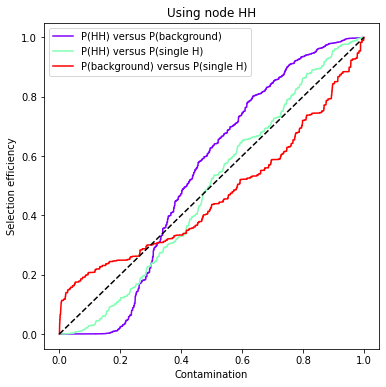

Saved multi ROC as multi_roc_test_odd_output_HH.pdf
Multi roc curve for `output background`


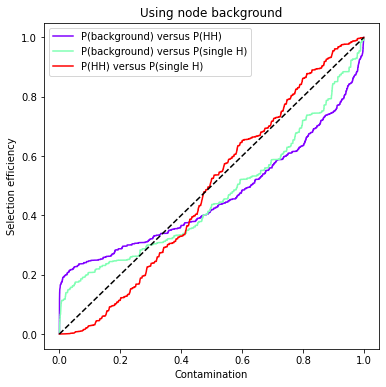

Saved multi ROC as multi_roc_test_odd_output_background.pdf
Multi roc curve for `output single H`


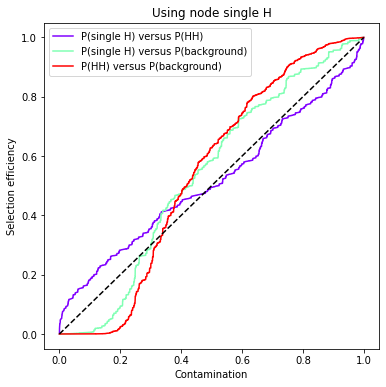

Saved multi ROC as multi_roc_test_odd_output_single H.pdf


In [142]:
import roc
importlib.reload(roc) # Reload in case file has changed
for tag in tags:
    print (f'ROC curve of binary classification of {tag} node versus all the others')
    roc.rocAndSig(y_true                 = test_df[tag],
                  y_pred                 = test_df[f'output {tag}'],
                  w_roc                  = test_df['training_weight'],
                  w_sig                  = test_df['event_weight'],
                  show_significance      = 'HH' in tag,
                  outputName             = f'roc_{suffix}_{split}_{tag}.pdf')

# Multiclassification ROC curves are a bit harder to interpret than binary classification
# Here I do one versus the rest, so each ROC curves shows how the DNN is able to classify
# one class (HH, single H or background) versus all the others, which is one projection on
# how to see the performances
# For HH I show the significance but more as an information, because using only the HH node 
# means we do not use all the power of the multiclass (-> d_HH is for that)
print (f'ROC curve of binary classification of d_HH')
roc.rocAndSig(y_true                 = test_df['HH'],
              y_pred                 = test_df['d_HH'],
              w_roc                  = test_df['training_weight'],
              w_sig                  = test_df['event_weight'],
              show_significance      = True,
              outputName             = f'roc_{suffix}_{split}_d_HH.pdf')

# Tryign a new things, seeing the discrimination power of each node, class wise
for tag in tags:
    print (f'Multi roc curve for `output {tag}`')
    tags_order = [tag] + [t for t in tags if t != tag]
    roc.multiRoc(outputs    = [test_df[test_df['tag']==tag][f'output {tag}'] for tag in tags_order],
                 tags       = tags_order,
                 weights    = [test_df[test_df['tag']==tag]['training_weight'] for tag in tags_order],
                 title      = f'Using node {tag}',
                 outputName = f'multi_roc_{suffix}_{split}_output_{tag}.pdf')

/nfs/scratch/fynu/fbury/ipykernel_2783870/1882814848.py:14: RuntimeWarning: invalid value encountered in sqrt
  return np.nan_to_num(np.sqrt(2*((s+b)*np.log(1+s/b)-s)))


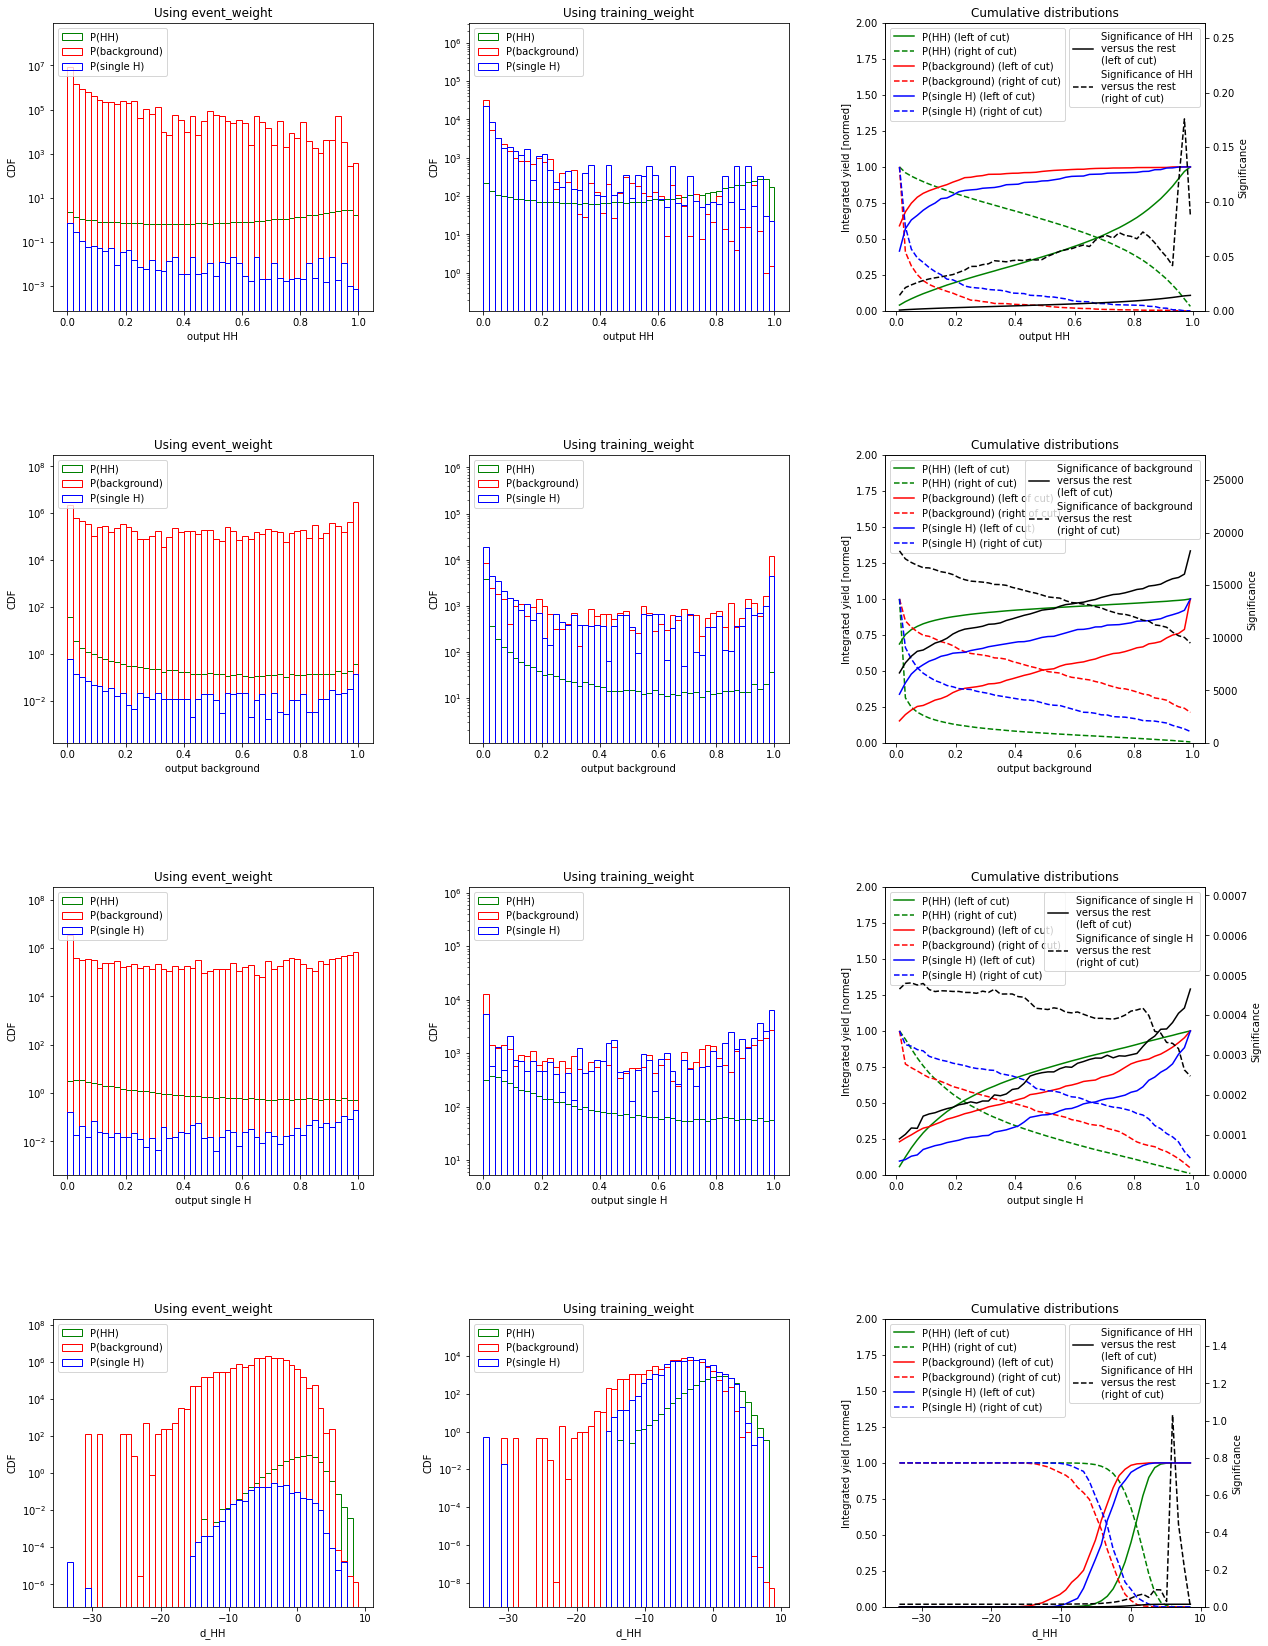

In [120]:
fig,axs = plt.subplots(figsize=(20,25),nrows=len(tags)+1,ncols=3)
fig.subplots_adjust(left=0.1, right=0.9, top=0.98, bottom=0.1, wspace=0.3,hspace=0.5)

tag_df = {tag:test_df[test_df['tag']==tag] for tag in tags}
colors = ['g','r','b']

# Manual binning so we can compute significance #
n_bins = 50

def get_bin_content(bins,y,w):
    digitized = np.digitize(y,bins)
    return np.array([w[digitized==i].sum() for i in range(1, len(bins))])
def significance(s,b):
    return np.nan_to_num(np.sqrt(2*((s+b)*np.log(1+s/b)-s)))

for irow,output_tag in enumerate(output_tags+['d_HH']):
    for icol,weight in enumerate(['event_weight','training_weight']):
        # Fill the bins myself #
        bins = np.linspace(test_df[output_tag].min(),test_df[output_tag].max(),n_bins+1)
        centers = (bins[1:]+bins[:-1])/2
        widths = np.diff(bins)
        
        tag_content = {tag:get_bin_content(bins,tag_df[tag][output_tag],tag_df[tag][weight])for tag in tags}
        tag_cumsum_left = {tag:np.cumsum(tag_content[tag]) for tag in tags}
        tag_cumsum_right = {tag:np.cumsum(tag_content[tag][::-1])[::-1] for tag in tags}
        
        # First : plot the histograms #
        for i,(tag,content) in enumerate(tag_content.items()):
            axs[irow,icol].bar(x=centers,height=content,width=widths,fill=False,edgecolor=colors[i],label=f'P({tag})')     

        axs[irow,icol].set_title(f'Using {weight}')
        axs[irow,icol].set_xlabel(output_tag)
        axs[irow,icol].set_ylabel('CDF')
        axs[irow,icol].set_ylim(min([content[content>0].min() for content in tag_content.values()])*0.1,
                                max([content.max() for content in tag_content.values()])*100)
        axs[irow,icol].set_yscale('log')
        axs[irow,icol].legend(loc='upper left')
        
        # Second : plot the cumulatives #
        if icol == 0:
            axs[irow,2].set_title("Cumulative distributions")
            axs[irow,2].set_xlabel(output_tag)
            axs[irow,2].set_ylabel('Integrated yield [normed]')
            axs[irow,2].set_ylim(0,2)

            for i,tag in enumerate(tags):
                axs[irow,2].plot(centers,tag_cumsum_left[tag]/tag_cumsum_left[tag].max(),color=colors[i],linestyle='-',label=f'P({tag}) (left of cut)')
                axs[irow,2].plot(centers,tag_cumsum_right[tag]/tag_cumsum_right[tag].max(),color=colors[i],linestyle='--',label=f'P({tag}) (right of cut)')
            axs[irow,2].legend(loc='upper left')
            
            ax2 = axs[irow,2].twinx()   
            if output_tag == 'd_HH':
                class_tag = "HH"
            else:
                class_tag = output_tag.replace('output ','')
            z_left = significance(tag_cumsum_left[class_tag],
                                  np.sum([c for tag,c in tag_cumsum_left.items() if tag != class_tag],axis=0))
            z_right = significance(tag_cumsum_right[class_tag],
                                  np.sum([c for tag,c in tag_cumsum_right.items() if tag != class_tag],axis=0))
            ax2.plot(centers,z_left,color='k',linestyle='-',label=f'Significance of {class_tag} \nversus the rest \n(left of cut)')
            ax2.plot(centers,z_right,color='k',linestyle='--',label=f'Significance of {class_tag} \nversus the rest \n(right of cut)')
            ax2.legend(loc='upper right')
            ax2.set_ylabel('Significance')
            ax2.set_ylim(0,max([z_left.max(),z_right.max()])*1.5)
            
fig.savefig(f"prediction_{suffix}_{split}.pdf", dpi = 300)



In [90]:
# evaluate the model
scores = model.evaluate(test_df[input_vars], 
                        test_df[tags], 
                        sample_weight = test_df['training_weight'], 
                        batch_size = 5000,
                        verbose=2)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

34/34 - 0s - loss: 0.9949 - binary_accuracy: 0.6049 - auc_1: 0.5389 - precision_1: 0.4003 - recall_1: 0.3720
binary_accuracy: 60.49%


In [ ]:
# save model and architecture to single file
modelName = f"model_{suffix}_{split}"
model.save(modelName)
print(f"Saved model to disk as {modelName}")